In [2]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
- Testing a proportional 3D heading control algorithm -
"""

import os
import numpy as np

# -- Graphic tools --
import matplotlib.pyplot as plt

# -- Our utils --
from simulations.utils.tools_math import *
from simulations.utils.tools_plot import *

from simulations.utils.tools_basic import createDir
from simulations.sim_test import sim_test
from simulations.sim_ss_test import sim_ss_test

from simulations.utils.tools_math import rot_3d_matrix, so3_hat, so3_vee, theta_distance_from_R, exp_map, log_map_of_R

In [2]:
Ra = rot_3d_matrix(np.pi, np.pi/2, 0)
R1 = rot_3d_matrix(np.pi/3, 0, 0)
kw = 1

def omega_law(Ra, R, omega_a=np.array([0,0,0])):
    Re = Ra.T @ R
    Omega_a = so3_hat(omega_a)
    return -kw*log_map_of_R(Re) + Re.T@Omega_a@Re

alpha_list = np.linspace(0,np.pi,100)

data = np.zeros((4,len(alpha_list),3,3))
for i,alpha in enumerate(alpha_list):
    R2 = rot_3d_matrix(alpha, alpha/2, 0)
    R12 = R2.T @ R1

    Omega_1 = omega_law(Ra,R1)
    Omega_2 = omega_law(Ra,R2)

    data[0,i,...] = log_map_of_R(R2.T@R1)
    data[1,i,...] = (Omega_1 - R12.T @ Omega_2 @ R12)
    data[2,i,...] = so3_hat(so3_vee(Omega_1) - R12.T @ so3_vee(Omega_2)) # (omega_law(Ra,R1) - R1.T @ omega_law(Ra,R2) @ R1)
    data[3,i,...] = -kw*so3_hat(so3_vee(log_map_of_R(Ra.T @ R1)) - R12.T @ so3_vee(log_map_of_R(Ra.T @ R2)))



li = 10
with np.printoptions(precision=4, suppress=True):
    print(data[0,li,...], "\n---")
    print(data[1,li,...], "\n---")
    print(data[2,li,...], "\n---")
    print(data[3,li,...], "\n---")
    #print(data[4,li,...], "\n---")

[[ 0.     -0.7309 -0.1264]
 [ 0.7309  0.      0.1033]
 [ 0.1264 -0.1033  0.    ]] 
---
[[-0.      0.2974  0.8668]
 [-0.2974  0.     -0.2358]
 [-0.8668  0.2358 -0.    ]] 
---
[[ 0.      0.2901  0.874 ]
 [-0.2901  0.     -0.2393]
 [-0.874   0.2393  0.    ]] 
---
[[-0.      0.2901  0.874 ]
 [-0.2901 -0.     -0.2393]
 [-0.874   0.2393 -0.    ]] 
---


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.0


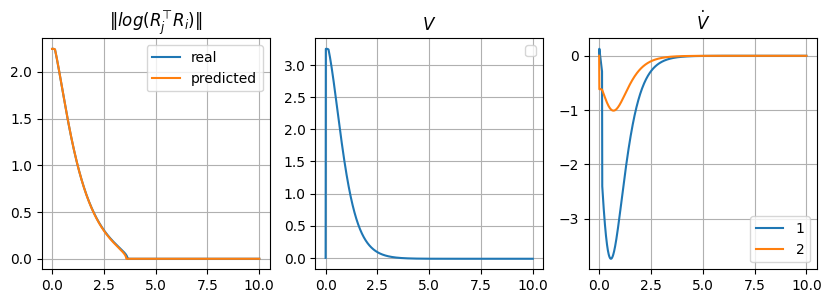

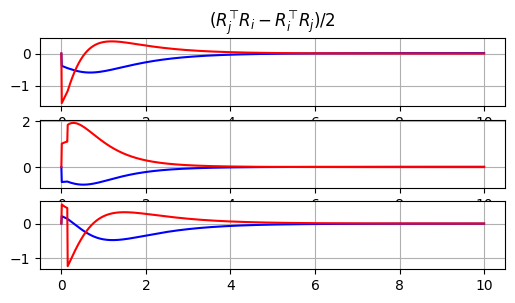

[]

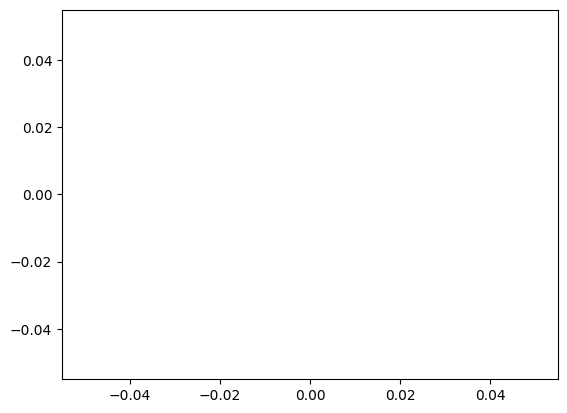

In [30]:
kw = 0.9
Ra = rot_3d_matrix(np.pi, -np.pi/2, 0)

R1 = rot_3d_matrix(np.pi/3, 0, 0)
R2 = rot_3d_matrix(0, np.pi/1.5, 0)
R12 = R2.T @ R1


def omega_law(R, omega_a=np.array([0,0,0])):
    Re = Ra.T @ R
    Omega_a = so3_hat(omega_a)
    return -kw*log_map_of_R(Re) + Re.T@Omega_a@Re

dt = 0.01
tf = 10
its = int(tf/dt)

tlist = np.linspace(0,dt*its,its)

R1_data = np.zeros((len(tlist),3,3))
R2_data = np.zeros((len(tlist),3,3))
R12_data = np.zeros((len(tlist),3,3))

R12_norm_data = np.zeros((len(tlist)))
R12_norm_pred_data = np.zeros((len(tlist)))

V_data = np.zeros((len(tlist)))

er_data = np.zeros((len(tlist),3))
eomega_data = np.zeros((len(tlist),3))

V_dot_data = np.zeros((len(tlist)))
V_dot_test_data = np.zeros((len(tlist)))

for i,t in enumerate(tlist):
    if i == 0:
        R1_data[i,:,:] = R1
        R2_data[i,:,:] = R2
        R12_data[i,:,:] = R12
        R12_norm_data[i] = theta_distance_from_R(R12)
        R12_norm_pred_data[i] = theta_distance_from_R(R12)

    else:
        Omega_1 = omega_law(R1_data[i-1,:,:])
        Omega_2 = omega_law(R2_data[i-1,:,:])

        R1_data[i,:,:] = R1_data[i-1,:,:]@exp_map(Omega_1*dt)
        R2_data[i,:,:] = R2_data[i-1,:,:]@exp_map(Omega_2*dt)

        Omega_1_c = log_map_of_R(Ra.T @ R1_data[i-1,:,:])
        Omega_2_c = log_map_of_R(Ra.T @ R2_data[i-1,:,:])

        Omega_12 = -kw*so3_hat(so3_vee(Omega_1_c) - R12_data[i-1,:,:].T @ so3_vee(Omega_2_c))
        R12_data[i,:,:] = R12_data[i-1,:,:]@exp_map(Omega_12*dt)

        # -----
        er = np.array(so3_vee((R12_data[i,:,:]) - R12_data[i,:,:].T)).T / 2
        eomega = np.array(so3_vee(Omega_12)).T

        er_data[i,:] = er
        eomega_data[i,:] = eomega

        #V_data[i] = er_data[i,:] @ er_data[i,:].T + np.trace(np.eye(3) - R12_data[i,:,:])
        V_data[i] = np.trace(np.eye(3) - R12_data[i,:,:])
        
        R12_norm_data[i] = theta_distance_from_R(R2_data[i,:,:].T@R1_data[i,:,:])
        R12_norm_pred_data[i] = theta_distance_from_R(R12_data[i,:,:])
        
        log_R12_vee = np.array([so3_vee(log_map_of_R(R12_data[i,:,:]))])
        Omega_12_vee = np.array([so3_vee(Omega_12)])
        Omega_diff_12_vee = np.array([so3_vee(Omega_2_c)]) - np.array([so3_vee(Omega_1_c)])

        V_dot_data[i] = er_data[i,:] @ eomega_data[i,:].T / er_data[i,:] @ er_data[i,:].T
        V_dot_test_data[i] = -er_data[i,:] @ er_data[i,:].T
        #V_dot_data[i] = log_R12_vee @ Omega_12_vee.T
        #V_dot_test_data[i] = -log_R12_vee @ log_R12_vee.T

with np.printoptions(precision=3, suppress=True):
    print(theta_distance_from_R(Ra.T@R1_data[-1,:,:]))

fig = plt.figure(figsize=(10,3))
axs = fig.subplots(1,3)

axs[0].set_title(r"$\|log(R_j^\top R_i)\|$")
axs[0].plot(tlist, R12_norm_data, label="real")
axs[0].plot(tlist, R12_norm_pred_data, label="predicted")
axs[0].grid(True)
axs[0].legend()

axs[1].set_title(r"$V$")
axs[1].plot(tlist, V_data)
axs[1].grid(True)
axs[1].legend()

axs[2].set_title(r"$\dot V$")
axs[2].plot(tlist, V_dot_data, label=r"$1$")
axs[2].plot(tlist, V_dot_test_data, label=r"$2$")
axs[2].grid(True)
axs[2].legend()

plt.show()

fig = plt.figure(figsize=(6,3))
axs = fig.subplots(3,1)

axs[0].set_title(r"$(R_j^\top R_i - R_i^\top R_j)/2$")
for i in range(3):
    axs[i].plot(tlist, er_data[:,i], c="b")
    axs[i].plot(tlist, eomega_data[:,i], c="red")
    axs[i].grid(True)

plt.show()

plt.plot()